cuda:0
Files already downloaded and verified
Files already downloaded and verified
Testing hyperparameters: lr=0.001, batch_size=64, weight_decay=0.004
	Fold 1/5
		Epoch 1/1, Training Accuracy: 0.1992, Training Loss: 4.611837981239198
Starting Validation Loop...
		Validation Accuracy: 0.0638, Validation Loss: 2.9264070317149162
	Test Accuracy: 0.3125, Test Loss: 2.9264070317149162
	Fold 2/5
		Epoch 1/1, Training Accuracy: 0.2166, Training Loss: 4.47705374445234
Starting Validation Loop...
		Validation Accuracy: 0.0546, Validation Loss: 3.4569029957056046
	Test Accuracy: 0.30275, Test Loss: 3.4569029957056046
	Fold 3/5
		Epoch 1/1, Training Accuracy: 0.2102, Training Loss: 4.710611600724477
Starting Validation Loop...
		Validation Accuracy: 0.063, Validation Loss: 2.7559943944215775
	Test Accuracy: 0.317125, Test Loss: 2.7559943944215775
	Fold 4/5
		Epoch 1/1, Training Accuracy: 0.1914, Training Loss: 4.556101621143402
Starting Validation Loop...
		Validation Accuracy: 0.0644, Validatio

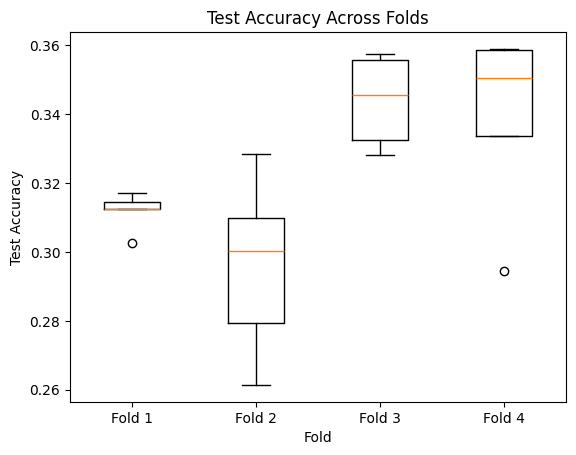

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import itertools
import sys


# Number of channels in the training images. For color images this is 3
nc = 3

# Size of feature maps in discriminator
ndf = 96
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(device)

class Encoder(nn.Module):
    def __init__(self, ngpu, dim_z, num_classes):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )
        self.fc = nn.Linear(dim_z, num_classes)

    def forward(self, input):
        z = self.main(input)
        z = z.view(input.size(0), -1)  # Flatten z to (batch_size, dim_z)
        c = self.fc(z)
        return c
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def train_model(train_loader, val_loader, device, num_epochs, learning_rate, batch_size, weight_decay):
    encoder = Encoder(ngpu=1, dim_z=64, num_classes=10).to(device)
    encoder.apply(weights_init)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        encoder.train()
        epoch_correct = 0
        epoch_loss_val = 0

        for i, (data, labels) in enumerate(train_loader, 0):
            data_real = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = encoder(data_real)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            predicted = torch.argmax(output.data, dim=1).to(device)
            correct = (predicted == labels).sum().item()

            epoch_correct += correct
            epoch_loss_val += loss.item()

        epoch_accuracy = epoch_correct / len(train_loader.dataset)
        avg_epoch_loss = epoch_loss_val / len(train_loader)

        print(f'\t\tEpoch {epoch + 1}/{num_epochs}, Training Accuracy: {epoch_accuracy}, Training Loss: {avg_epoch_loss}')
        


    print('Starting Validation Loop...')
    encoder.eval()
    val_correct = 0
    val_loss_value = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data_real = data.to(device)
            labels = labels.to(device)
            output = encoder(data_real)
            v_loss = criterion(output, labels)
            predicted = torch.argmax(output.data, dim=1).to(device)
            val_correct += (predicted == labels).sum().item()
            val_loss_value += v_loss.item()

    val_accuracy = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss_value / len(val_loader)

    print(f"\t\tValidation Accuracy: {val_accuracy}, Validation Loss: {avg_val_loss}")

    return encoder, avg_val_loss

image_size = 96
# Create a new transformation that resizes the images
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Define datasets
train_dataset = STL10(root='./data', split='train', transform=transform, download=True)
test_dataset = STL10(root='./data', split='test', transform=transform, download=True)

# Define hyperparameter grid
lr_values = [0.001, 0.0001]#, 0.01, 0.001, 0.0001]
bs_values = [64]#, 128, 256]
wd_values = [0.004, 0.0004]#, 0.04, 0.004, 0.0004]

# Perform hyperparameter tuning
best_hyperparameters = None
best_avg_accuracy = 0.0

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5


num_epochs = 100



all_test_accuracies = []
best_fold = None
for lr, bs, wd in itertools.product(lr_values, bs_values, wd_values):
    print(f"Testing hyperparameters: lr={lr}, batch_size={bs}, weight_decay={wd}")



    # Initialize average accuracy for this set of hyperparameters
    avg_accuracy = 0.0

    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    fold_test_accuracies = []  # Store test accuracies for each fold

    
    for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
        print(f"\tFold {fold + 1}/5")

        train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

        train_loader = DataLoader(train_dataset, batch_size=bs, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=bs, sampler=val_sampler)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

        # Train the model for this set of hyperparameters
        encoder, avg_val_loss = train_model(train_loader, val_loader, device, learning_rate=lr, batch_size=bs, weight_decay=wd, num_epochs=num_epochs)

        # Evaluate the model on the test set
        encoder.eval()
        test_correct = 0
        with torch.no_grad():
            for data, labels in test_loader:
                data_real = data.to(device)
                labels = labels.to(device)
                output = encoder(data_real)
                predicted = torch.argmax(output.data, dim=1).to(device)
                test_correct += (predicted == labels).sum().item()
        test_accuracy = test_correct / len(test_dataset)

        print(f"\tTest Accuracy: {test_accuracy}, Test Loss: {avg_val_loss}")

        avg_accuracy += test_accuracy / 5  # Add test accuracy for this fold
        fold_test_accuracies.append(test_accuracy)
        

        # Update best hyperparameters if this set is better
        if avg_accuracy > best_avg_accuracy:
            best_avg_accuracy = avg_accuracy
            best_fold = fold
            best_hyperparameters = {'lr': lr, 'batch_size': bs, 'weight_decay': wd, 'fold': best_fold}
            best_model_state = encoder.main.state_dict()
    
    
    all_test_accuracies.append(fold_test_accuracies)

    print(f"Average Test Accuracy: {avg_accuracy}")
    
print(f"Best Hyperparameters: {best_hyperparameters}")
# Save the box plot
plt.boxplot(all_test_accuracies, labels=[f'Fold {i+1}' for i in range(len(all_test_accuracies))])
plt.xlabel('Fold')
plt.ylabel('Test Accuracy')
plt.title('Supervised Baseline 5-Fold CV - Test Accuracy Across Folds')
plt.savefig('SBL5CV_box_plot.png')


learning_rate = best_hyperparameters['lr']
batch_size = best_hyperparameters['batch_size']
weight_decay = best_hyperparameters['weight_decay']
fold = best_hyperparameters['fold']

# Save the best model
if best_model_state is not None:
    PATH = '../models/sbl_5cv{}_{}_{}_F{}.pth'.format(learning_rate, batch_size, weight_decay, fold)
    torch.save(best_model_state, PATH)